# Libraries

In [1]:
##get_ipython().kernel.do_shutdown(restart=True)       # Tor Restart the Kernal explicitly

In [2]:
!nvidia-smi  # this should display information about available GPUs
!pip install cudf-cu12 --extra-index-url=https://pypi.nvidia.com
import cudf  # this should work without any errors
!pip install plotly-express
%load_ext cudf.pandas

Fri Jan 12 14:25:49 2024       
+---------------------------------------------------------------------------------------+
| NVIDIA-SMI 535.104.05             Driver Version: 535.104.05   CUDA Version: 12.2     |
|-----------------------------------------+----------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |         Memory-Usage | GPU-Util  Compute M. |
|                                         |                      |               MIG M. |
|=========================================+======================+======================|
|   0  Tesla T4                       Off | 00000000:00:04.0 Off |                    0 |
| N/A   65C    P8              10W /  70W |      0MiB / 15360MiB |      0%      Default |
|                                         |                      |                  N/A |
+-----------------------------------------+----------------------+--

# **Importing Libraries**

In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
sns.set(rc={'figure.figsize':(18,8)},style='darkgrid')
from time import time
import re
import string
import nltk
from imblearn.over_sampling import RandomOverSampler
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import *
import warnings
warnings.filterwarnings('ignore')

# **Load Dataset**

In [4]:
train = pd.read_csv("/content/train_data.txt", sep=':::', header=None, names=['ID', 'TITLE', 'GENRE', 'DESCRIPTION']).reset_index(drop=True)

In [5]:
train.head()

,ID,TITLE,GENRE,DESCRIPTION
0,1,Oscar et la dame rose (2009),drama,Listening in to a conversation between his do...
1,2,Cupid (1997),thriller,A brother and sister with a past incestuous r...
2,3,"Young, Wild and Wonderful (1980)",adult,As the bus empties the students for their fie...
3,4,The Secret Sin (1915),drama,To help their unemployed father make ends mee...
4,5,The Unrecovered (2007),drama,The film's title refers not only to the un-re...


In [6]:
train.tail()

,ID,TITLE,GENRE,DESCRIPTION
54209,54210,"""Bonino"" (1953)",comedy,This short-lived NBC live sitcom centered on ...
54210,54211,Dead Girls Don't Cry (????),horror,The NEXT Generation of EXPLOITATION. The sist...
54211,54212,Ronald Goedemondt: Ze bestaan echt (2008),documentary,"Ze bestaan echt, is a stand-up comedy about g..."
54212,54213,Make Your Own Bed (1944),comedy,Walter and Vivian live in the country and hav...
54213,54214,Nature's Fury: Storm of the Century (2006),history,"On Labor Day Weekend, 1935, the most intense ..."


In [7]:
train.describe()

,ID
count,54214.000000
mean,27107.500000
std,15650.378084
min,1.000000
25%,13554.250000
50%,27107.500000
75%,40660.750000
max,54214.000000


In [8]:
train.info()

<class 'cudf.core.dataframe.DataFrame'>
RangeIndex: 54214 entries, 0 to 54213
Data columns (total 4 columns):
 #   Column       Non-Null Count  Dtype
---  ------       --------------  -----
 0   ID           54214 non-null  int64
 1   TITLE        54214 non-null  object
 2   GENRE        54214 non-null  object
 3   DESCRIPTION  54214 non-null  object
dtypes: int64(1), object(3)
memory usage: 34.0+ MB


In [9]:
print(train.isnull().sum())

ID             0
TITLE          0
GENRE          0
DESCRIPTION    0
dtype: int64


# **Test Data**

In [10]:
test = pd.read_csv(r"/content/test_data.txt", sep=':::',names=['ID', 'TITLE','DESCRIPTION']).reset_index(drop=True)
test.head()

,ID,TITLE,DESCRIPTION
0,1,Edgar's Lunch (1998),"L.R. Brane loves his life - his car, his apar..."
1,2,La guerra de papá (1977),"Spain, March 1964: Quico is a very naughty ch..."
2,3,Off the Beaten Track (2010),One year in the life of Albin and his family ...
3,4,Meu Amigo Hindu (2015),"His father has died, he hasn't spoken with hi..."
4,5,Er nu zhai (1955),Before he was known internationally as a mart...


In [11]:
test.tail()

,ID,TITLE,DESCRIPTION
54195,54196,"""Tales of Light & Dark"" (2013)","Covering multiple genres, Tales of Light & Da..."
54196,54197,Der letzte Mohikaner (1965),As Alice and Cora Munro attempt to find their...
54197,54198,Oliver Twink (2007),A movie 169 years in the making. Oliver Twist...
54198,54199,Slipstream (1973),"Popular, but mysterious rock D.J Mike Mallard..."
54199,54200,Curitiba Zero Grau (2010),"Curitiba is a city in movement, with rhythms ..."


In [12]:
num_features = len(train.columns)

print(f'The number of features in the train dataset is: {num_features}')

The number of features in the train dataset is: 4


In [13]:
num_features1 = len(test.columns)

print(f'The number of features in the test dataset is: {num_features1}')

The number of features in the test dataset is: 3


# **Data Cleaning**

### For Train Data


In [14]:
train.describe(include='object').T

,count,unique,top,freq
TITLE,54214,54214,Oscar et la dame rose (2009),1
GENRE,54214,27,drama,13613
DESCRIPTION,54214,54086,Grammy - music award of the American academy ...,12


In [15]:
train.shape

(54214, 4)

we have **54214** rows and **4** columns

In [16]:
train.info() #No null values

<class 'cudf.core.dataframe.DataFrame'>
RangeIndex: 54214 entries, 0 to 54213
Data columns (total 4 columns):
 #   Column       Non-Null Count  Dtype
---  ------       --------------  -----
 0   ID           54214 non-null  int64
 1   TITLE        54214 non-null  object
 2   GENRE        54214 non-null  object
 3   DESCRIPTION  54214 non-null  object
dtypes: int64(1), object(3)
memory usage: 34.0+ MB


In [17]:
train.duplicated().sum() #No duplicate rows

0

In [18]:
missing_rows = train[train['GENRE'].isna()]

# Display the rows with missing values in the 'GENRE' column
print(missing_rows)

Empty DataFrame
Columns: [ID, TITLE, GENRE, DESCRIPTION]
Index: []


**There are no missing values in the dataset**

In [19]:
###train_df['GENRE'].dropna(inplace=True)  # Drop rows with missing values

In [20]:
unique_values_count = train['GENRE'].nunique()

if unique_values_count > 0:
    print(f"There are {unique_values_count} unique values in the 'GENRE' column.")
else:
    print("There are no unique values in the 'GENRE' column.")

There are 27 unique values in the 'GENRE' column.


In [21]:
train.GENRE.unique() #No anomalies values

array([' drama ', ' thriller ', ' adult ', ' documentary ', ' comedy ',
       ' crime ', ' reality-tv ', ' horror ', ' sport ', ' animation ',
       ' action ', ' fantasy ', ' short ', ' sci-fi ', ' music ',
       ' adventure ', ' talk-show ', ' western ', ' family ', ' mystery ',
       ' history ', ' news ', ' biography ', ' romance ', ' game-show ',
       ' musical ', ' war '], dtype=object)

We have **27 unique genres** in our dataset so we will have to **reduce our target classe**

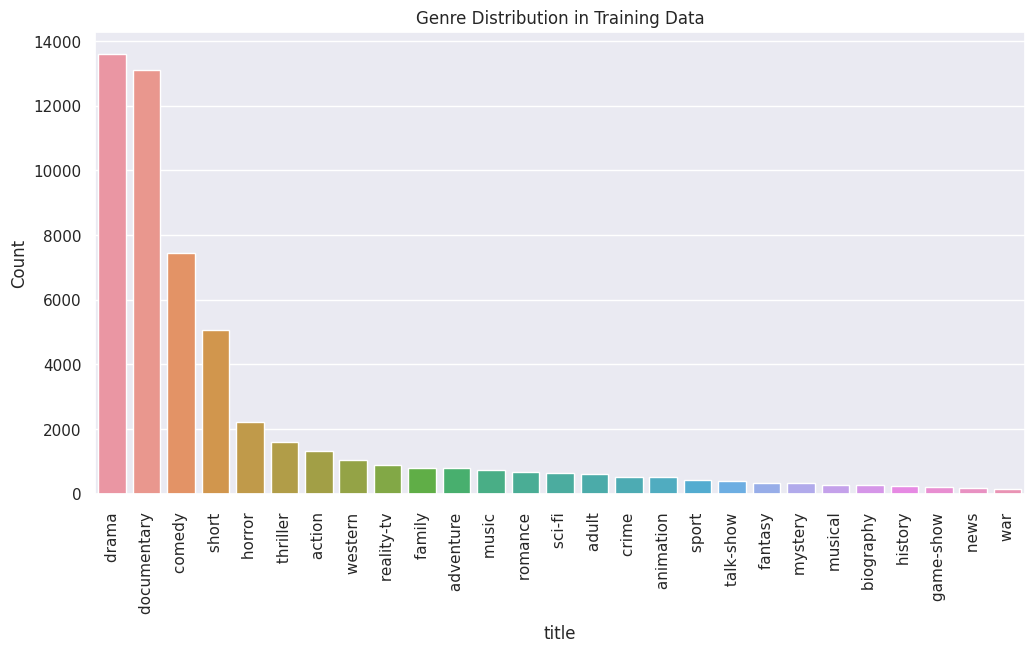

 drama           13613
 documentary     13096
 comedy           7447
 short            5073
 horror           2204
 thriller         1591
 action           1315
 western          1032
 reality-tv        884
 family            784
 adventure         775
 music             731
 romance           672
 sci-fi            647
 adult             590
 crime             505
 animation         498
 sport             432
 talk-show         391
 fantasy           323
 mystery           319
 musical           277
 biography         265
 history           243
 game-show         194
 news              181
 war               132
Name: GENRE, dtype: int64


In [22]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns


genre_distribution = train['GENRE'].value_counts()

# Visualize Genre Distribution
plt.figure(figsize=(12, 6))
sns.countplot(x='GENRE', data=train, order=genre_distribution.index)
plt.xticks(rotation=90)
plt.title('Genre Distribution in Training Data')
plt.xlabel('title')
plt.ylabel('Count')
plt.show()

# Display summary statistics
print(genre_distribution)

**It shows that their is inbalance in our dataset which we need to make it balanced for training our model correctly so that it can classify the genres.**

In my movie genre classification project, I have a range of options to address the imbalanced nature of my dataset. These options include:

**Resampling Techniques:**

I can opt for Random Undersampling to randomly reduce instances of the majority class, creating a more balanced representation of genres. Alternatively, I might consider Random Oversampling to randomly increase instances in minority classes, providing a broader and more diverse dataset. The use of SMOTE (Synthetic Minority Over-sampling Technique) is available as an option, allowing me to generate synthetic examples for minority classes and augment the dataset with additional diverse samples.

**Ensemble Methods:**

The Balance Cascade method is on the table, involving iteratively training models and adjusting class distribution to improve the representation of minority genres. Another option is the Easy Ensemble approach, where I can train multiple models on balanced subsets of the data, promoting an equal distribution of different genres among these models.

**Modified Algorithms:**

I can explore the option of adapting decision tree algorithms using the Modified Decision Trees strategy, making them more suitable for handling imbalanced data. For Support Vector Machines (SVM), I have the flexibility to modify the algorithm itself, creating a version that is tailored to handle imbalanced classes effectively in my movie genre dataset.

**### For Test Data**

In [23]:
test.describe(include='object').T

,count,unique,top,freq
TITLE,54200,54200,Edgar's Lunch (1998),1
DESCRIPTION,54200,54072,Grammy - music award of the American academy ...,10


Here **54072** descriptions are unique out of **54200** descriptions.

**54200** - **54072** = **128** duplicates descriptions

In [24]:
test.shape

(54200, 3)

In [25]:
test.info() #No null values

<class 'cudf.core.dataframe.DataFrame'>
RangeIndex: 54200 entries, 0 to 54199
Data columns (total 3 columns):
 #   Column       Non-Null Count  Dtype
---  ------       --------------  -----
 0   ID           54200 non-null  int64
 1   TITLE        54200 non-null  object
 2   DESCRIPTION  54200 non-null  object
dtypes: int64(1), object(2)
memory usage: 33.3+ MB


In [26]:
test.duplicated().sum() #No duplicate rows

0

In [27]:
missing_row = test[test['DESCRIPTION'].isna()]

# Display the rows with missing values in the 'DESCRIPTION' column of test dataset
print(missing_row)

Empty DataFrame
Columns: [ID, TITLE, DESCRIPTION]
Index: []


# **Exploratory Data Analysis (EDA) & Visualization**

# **TRAIN DATASET**

In [28]:
import plotly.express as px
import plotly.graph_objects as go

# Plot the distribution of genres using Plotly Express
fig1 = px.bar(train['GENRE'].value_counts().reset_index(),
              x='index',
              y='GENRE',
              labels={'index': 'GENRE', 'GENRE': 'Count'},
              title='Distribution of Genres',
              template='plotly',
              color='GENRE',
              color_continuous_scale='viridis')

fig1.update_layout(
    xaxis=dict(title='GENRE', tickangle=45, tickfont=dict(size=10)),
    yaxis=dict(title='Count'),
)

fig1.show()

# **Histogram of Description Length**

In [29]:
import plotly.express as px

# Assuming 'description' is the column containing the text descriptions
train['length'] = train['DESCRIPTION'].apply(len)

# Create a histogram using Plotly Express
fig = px.histogram(train, x='length', nbins=100, title='Histogram of Length of DESCRIPTION',
                   labels={'length': 'Length', 'count': 'Frequency'})

# Show the plot
fig.show()

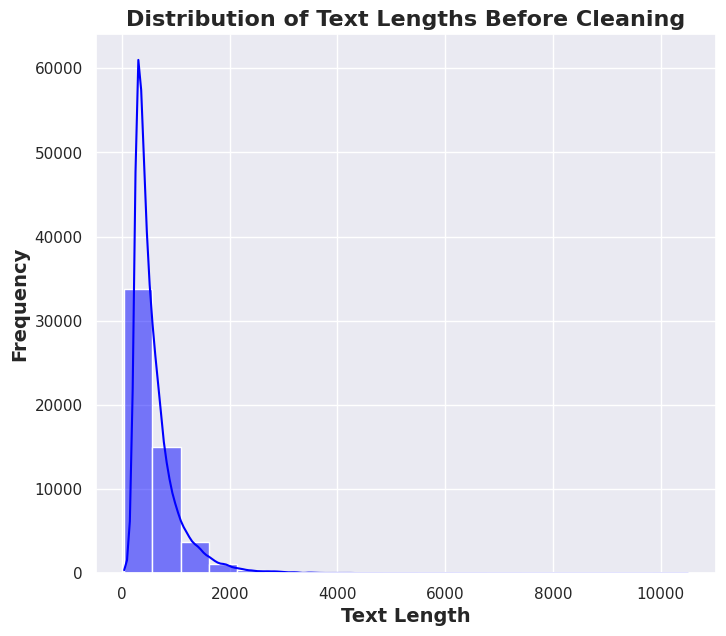

In [30]:
# Visualize the distribution of text lengths using plotting
plt.figure(figsize=(8, 7))
sns.histplot(data=train, x='length', bins=20, kde=True, color='blue')
plt.xlabel('Text Length', fontsize=14, fontweight='bold')
plt.ylabel('Frequency', fontsize=14, fontweight='bold')
plt.title('Distribution of Text Lengths Before Cleaning', fontsize=16, fontweight='bold')
plt.show()

# **Mean Description Length by Genre**

In [31]:
import plotly.express as px

# Assuming 'genre' and 'length' are the column names in your DataFrame
grp_df = train.groupby('GENRE')['length'].mean().reset_index()

# Create a bar chart using Plotly Express
fig = px.bar(grp_df, x='GENRE', y='length', title='Mean Length by Genre Before Cleaning',
             labels={'genre': 'GENRE', 'length': 'Mean Description Length'})

# Show the plot
fig.show()

# **Univariate Analysis - Bar Chart**

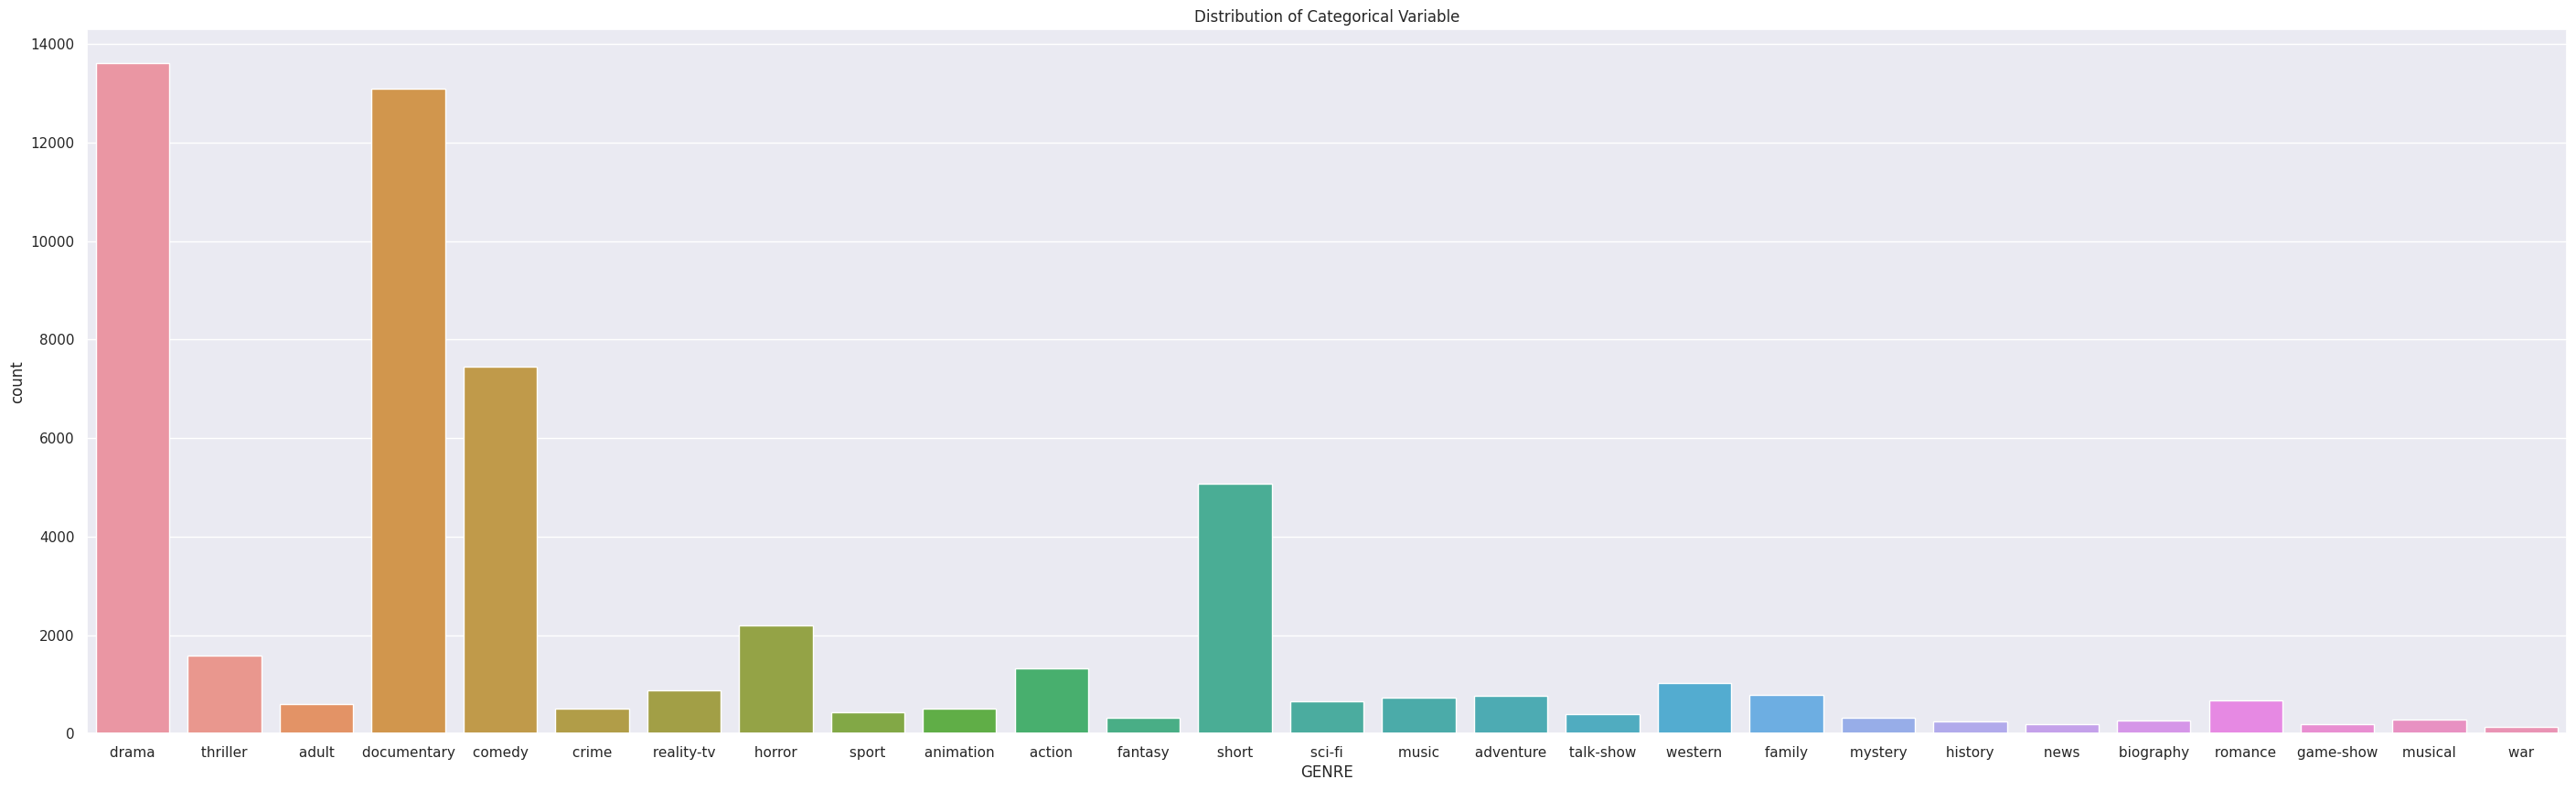

In [32]:
plt.figure(figsize=(35, 10))
sns.countplot(x='GENRE', data=train)
plt.title('Distribution of Categorical Variable')
plt.show()

# **Univariate Analysis - Pie Chart**

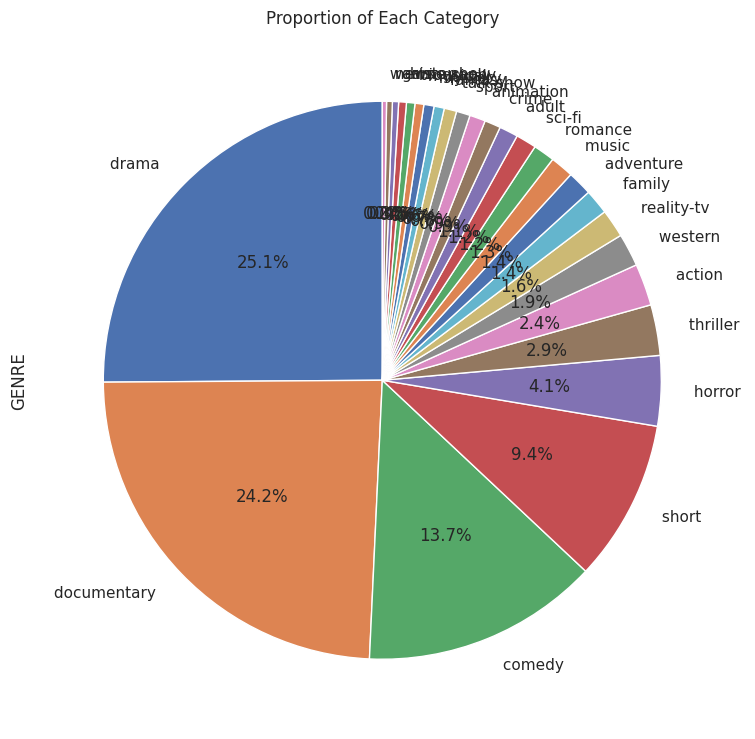

In [33]:
# Univariate Analysis - Pie Chart
plt.figure(figsize=(9, 13))
train['GENRE'].value_counts().plot.pie(autopct='%1.1f%%', startangle=90)
plt.title('Proportion of Each Category')
plt.show()

# Finding the most common pairs of words used in these movie descriptions. This could reveal interesting patterns or help you understand what terms are closely associated with each other.

In [34]:
from sklearn.feature_extraction.text import CountVectorizer
def get_top_n_bigram(text, ngram=1, top=None):
    vec = CountVectorizer(ngram_range=(ngram, ngram), stop_words='english').fit(text)
    bag_of_words = vec.transform(text)

    sum_words = bag_of_words.sum(axis=0)
    words_freq = [(word, sum_words[0, idx]) for word, idx in vec.vocabulary_.items()]

    words_freq =sorted(words_freq, key = lambda x: x[1], reverse=True)
    return words_freq[:top]

# **Top 30 Single Words (Unigrams):**

It finds and lists the 30 most frequently occurring single words in the movie descriptions. For example, if "love" or "action" appears frequently, they would be on this list.
# **Top 30 Pairs of Words (Bigrams):**

It identifies and lists the 30 most common pairs of consecutive words in the movie descriptions. This can reveal which words often appear together, providing insights into phrases like "science fiction" or "romantic comedy."

# **Top 30 Sets of Three Consecutive Words (Trigrams):**

Similar to bigrams, but it looks for sets of three consecutive words that frequently occur together. This could reveal more complex patterns or expressions in the movie descriptions.
In simpler terms, these analyses help you understand which individual words, pairs of words, and sets of three consecutive words are used most often in the movie descriptions. This information can be valuable for understanding the common themes or topics in the data.

In [35]:
top_30_unigrams = get_top_n_bigram(train.DESCRIPTION, ngram=1, top=30)
top_30_bigrams = get_top_n_bigram(train.DESCRIPTION, ngram=2, top=30)
top_30_trigrams = get_top_n_bigram(train.DESCRIPTION, ngram=3, top=30)

# **Top 30 Unigrams**

In [36]:
df1 = pd.DataFrame(top_30_unigrams, columns = ['unigram' , 'count'])
fig = px.bar(df1, x='unigram', y='count', title='Top 30 Unigrams', color='unigram')
fig.update_layout(xaxis_title='Unigram', yaxis_title='Count')
fig.update_xaxes(tickangle=80)

fig.show()

# **Top 30 Bigrams**

In [37]:
df1 = pd.DataFrame(top_30_bigrams, columns = ['unigram' , 'count'])
fig = px.bar(df1, x='unigram', y='count', title='Top 30 Unigrams', color='unigram')
fig.update_layout(xaxis_title='Unigram', yaxis_title='Count')
fig.update_xaxes(tickangle=80)

fig.show()

# **Top 30 Tigrams**

In [38]:
df1 = pd.DataFrame(top_30_trigrams, columns = ['unigram' , 'count'])
fig = px.bar(df1, x='unigram', y='count', title='Top 30 Unigrams', color='unigram')
fig.update_layout(xaxis_title='Unigram', yaxis_title='Count')
fig.update_xaxes(tickangle=80)

fig.show()

# **Data Preprocessing and Text Cleaning**

**Searching for anomalies in description:**
*   Punctuation: Remove unnecessary symbols or punctuation.
*   HTTP: Eliminate any web links (HTTP/HTTPS) if not essential.
*   Numbers: Review and ensure the relevance and accuracy of numbers. Remove unnecessary or irrelevant ones.



In [39]:
train.loc[train['DESCRIPTION'].str.contains(r'@\S+')].head()                  # Filter 'train_df' rows with email addresses in the 'DESCRIPTION' column and show the first few matches
                                                                              # matching_rows = train_df[train_df['DESCRIPTION'].str.contains(r'@\S+')].head()

,ID,TITLE,GENRE,DESCRIPTION,length
242,243,Túlvilági beszélö (1992),documentary,Mail <svaradi@sprynet.com> for translation. T...,879
1880,1881,Rokonok (1954),drama,Mail <svaradi@sprynet.com> for translation. F...,362
1986,1987,Lila akác (1934),comedy,Mail <svaradi@sprynet.com> for translation. S...,187
6579,6580,A csúnya lány (1935),comedy,Mail <svaradi@sprynet.com> for translation. D...,327
8296,8297,Füszer és csemege (1940),drama,Mail <svaradi@sprynet.com> for translation. 5...,293


In [40]:
#Descriptions included HTTP links
train.loc[train['DESCRIPTION'].str.contains(r'http\S+')].shape[0]

9

In [41]:
#For example
train.loc[train['DESCRIPTION'].str.contains(r'http\S+')].head()['DESCRIPTION'].iloc[1]
#So we need to remove them from our text

" There's more to the story of the Clintons and 9/11. Over two nights -- September 10-11, 2006, just four months before Hillary announced the exploratory committee for her original presidential campaign, ABC aired The Path to 9/11, a riveting and factual docudrama. This acclaimed and balanced movie faulted two administrations -- Bill Clinton and George W. Bush. But fairness was not what Hillary wanted. Screenwriter Cyrus Nowrasteh told me he had expected the customary DVD distribution. But the Clintons, fearing the impact of DVD release during her campaign, successfully pressured Disney, which owns ABC, to bury the movie. This is a portion of a news article that originally appeared: http://www.frontpagemag.com/fpm/261541/hillarys-path-back-911-arnold-steinberg This article originally appeared in The Huffington Post http://www.huffingtonpost.com/arnold-steinberg/hillarys-path-back-to-911_b_9039658.html This article was written by Arnold Steinberg from Huffington Post and was legally lic

## **Cleaning Text Function**

In [42]:
def clean_text(text):
    # Remove strange pattern in different languages if exist
    text = re.sub('Mail <svaradi@sprynet.com> for translation. ','',text)
    # Remove twitter handles
    text = re.sub(r'@\S+', '', text)
    # Remove URLs
    text = re.sub(r'http\S+', '', text)
    # Remove punctuations
    text = re.sub(f'[{string.punctuation}]','',text)
    # Remove numbers
    text = re.sub(f'[{string.digits}]','',text)
    # Remove single charachters
    text = re.sub(r'\s+[a-zA-Z]\s+', ' ', text)

    return text

In [43]:
#Clean Descriptions
train['DESCRIPTION'] = train['DESCRIPTION'].apply(clean_text)
test['DESCRIPTION'] = test['DESCRIPTION'].apply(clean_text)

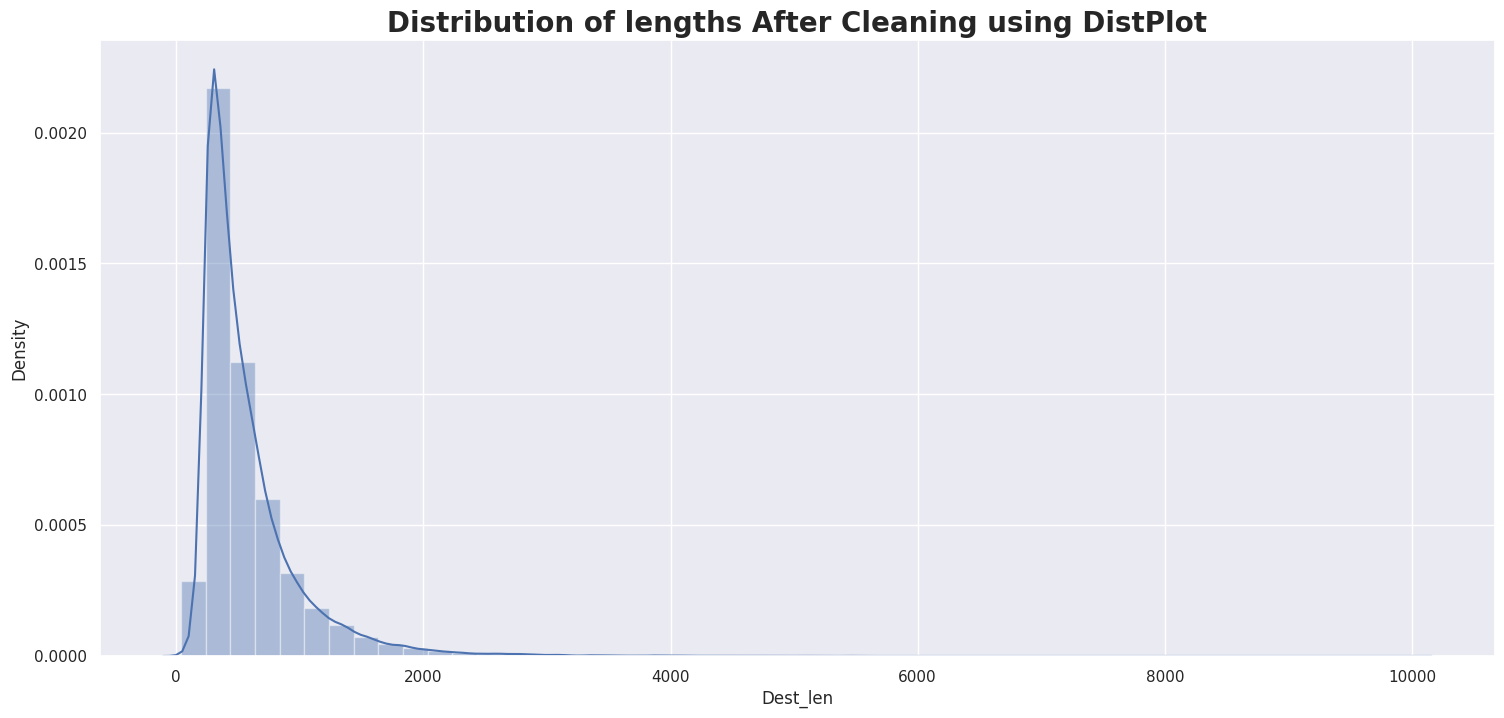

In [44]:
#Distribution of text lengths
train['Dest_len'] = train['DESCRIPTION'].apply(len)
sns.distplot(train['Dest_len'])
plt.title('Distribution of lengths After Cleaning using DistPlot',fontweight='bold',fontsize=20)
plt.show()

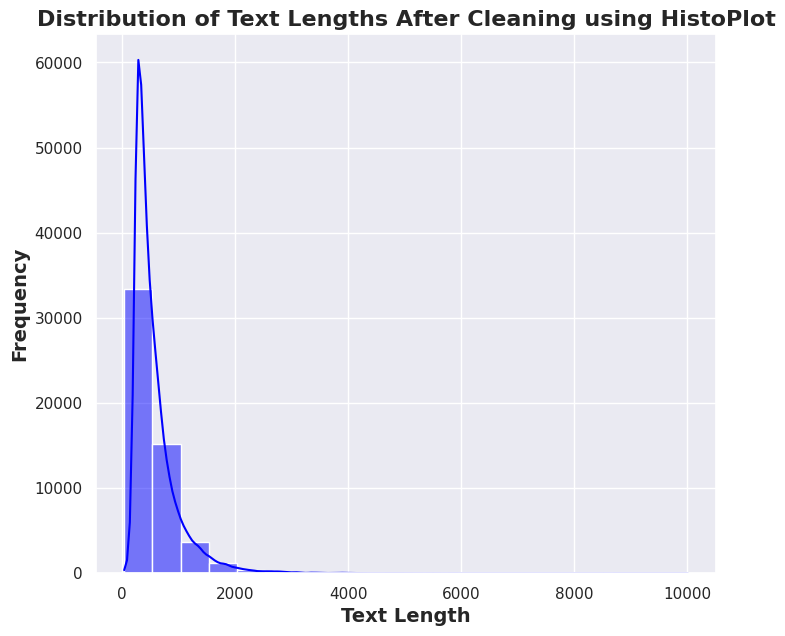

In [45]:
# Calculate the length of cleaned text
train['Text_Length'] =train['DESCRIPTION'].apply(len)

# Visualize the distribution of text lengths
plt.figure(figsize=(8, 7))
sns.histplot(data=train, x='Text_Length', bins=20, kde=True, color='blue')
plt.xlabel('Text Length', fontsize=14, fontweight='bold')
plt.ylabel('Frequency', fontsize=14, fontweight='bold')
plt.title('Distribution of Text Lengths After Cleaning using HistoPlot', fontsize=16, fontweight='bold')
plt.show()

# **We can even use Histogram**

In [46]:
train['length_cleaned']=train['DESCRIPTION'].apply(len)
fig = px.histogram(train, x='length_cleaned', nbins=100, title='Histogram of Text Lengths After Cleaning using HistoPlot')
fig.update_layout(xaxis_title='Length', yaxis_title='Frequency')
fig.show()

In [47]:
import plotly.express as px
import plotly.graph_objects as go

# Plot the distribution of genres using Plotly Express
fig1 = px.bar(train['GENRE'].value_counts().reset_index(),
              x='index',
              y='GENRE',
              labels={'index': 'GENRE', 'GENRE': 'Count'},
              title='Distribution of Genres',
              template='plotly',
              color='GENRE',
              color_continuous_scale='viridis')

fig1.update_layout(
    xaxis=dict(title='GENRE', tickangle=45, tickfont=dict(size=10)),
    yaxis=dict(title='Count'),
)

# Plot the distribution of genres using Plotly Graph Objects
fig2 = go.Figure()

fig2.add_trace(go.Bar(
    x=train['GENRE'].value_counts().index,
    y=train['GENRE'].value_counts(),
    marker=dict(color='steelblue')  # Use a specific color for the bars
))

fig2.update_layout(
    title='Genres Distribution',
    xaxis=dict(title='GENRE', tickangle=45, tickfont=dict(size=10)),
    yaxis=dict(title='Count'),
)

fig2.update_traces(marker_line_width=1, marker_line_color="black")

# Show interactive plots
fig1.show()
fig2.show()


# **Word Clouds (Common Words in Descriptions)**

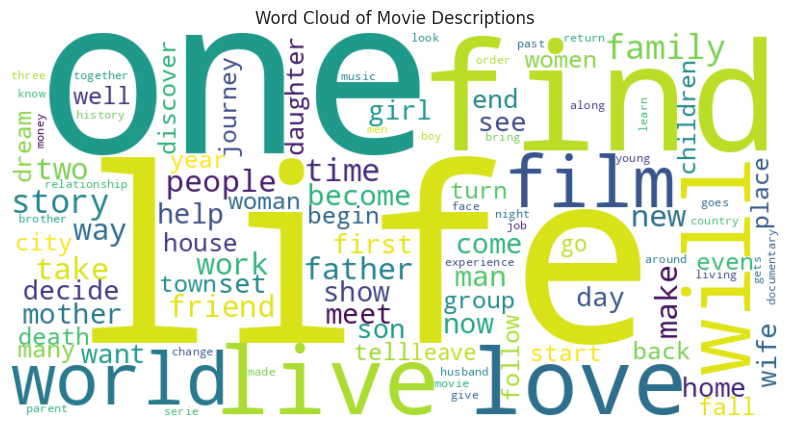

In [48]:
from wordcloud import WordCloud
import matplotlib.pyplot as plt
import re

# Combine all descriptions into a single text
all_descriptions = ' '.join(train['DESCRIPTION'])

# Preprocess the text (remove non-alphanumeric characters)
all_descriptions = re.sub(r'[^a-zA-Z\s]', '', all_descriptions)

# Generate and display a word cloud
wordcloud = WordCloud(width=800, height=400, max_words=100, background_color='white').generate(all_descriptions)

plt.figure(figsize=(10, 5))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.title('Word Cloud of Movie Descriptions')
plt.show()

# Model Building

In [49]:
# Using TfidfVectorizer
tfidf_vectorizer = TfidfVectorizer(lowercase=True, #Lowercase chars
                                   ngram_range=(1,3), #Capture Sets of Three Consecutive Words (Trigrams)
                                   stop_words='english',#Remove stop_words
                                   min_df=2)#Ignore words that appears less than 2 times
x_train = tfidf_vectorizer.fit_transform(train['DESCRIPTION'])
x_test = tfidf_vectorizer.transform(test['DESCRIPTION'])


In [50]:
#We conclude before that drama and documentary have the majority of our data,
#so to avoid imbalance data in our model we will make randomoversampling
#Notice that the accuracy before sampling will be < the accuracy after oversampling
sampler = RandomOverSampler()
#We will pass to it the output of TfidfVectorizer from train data
x_train_resampled , y_train_resampled = sampler.fit_resample(x_train,train['GENRE'])

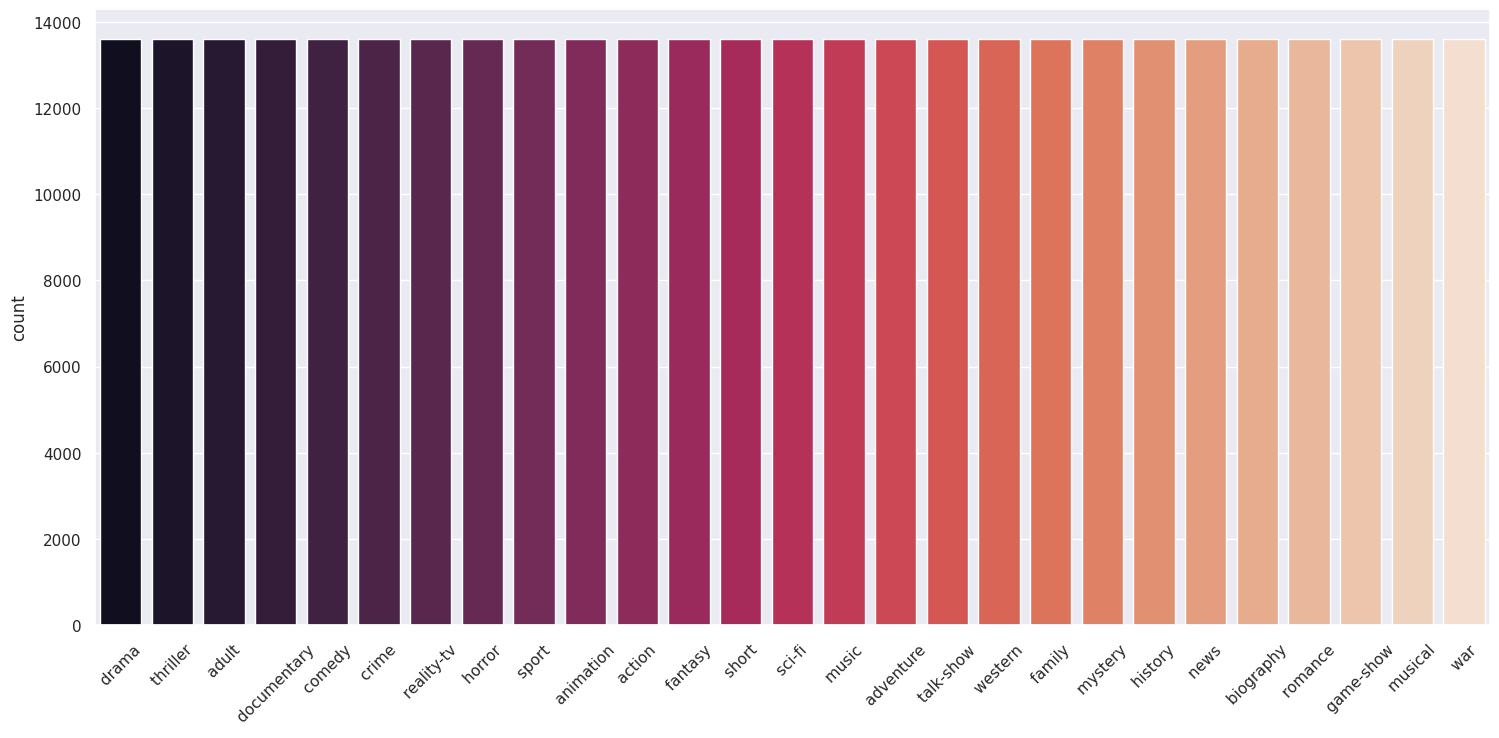

In [51]:
#Let's take a look on genre distribution
sns.countplot(data=y_train_resampled,x=y_train_resampled.values,palette='rocket')
plt.xticks(rotation=45)
plt.show()

In [52]:
#Double check for length of our data
print('Train :',x_train_resampled.shape[0])
print('Test :',y_train_resampled.shape[0])

Train : 367551
Test : 367551


In [53]:
#Get the actual solutions to compare it with our predictions
y_actual = pd.read_csv(r"/content/test_data_solution.txt",
                      sep=':::',usecols=[2],header=None).rename(columns={2:'Actual_Genre'})
y_actual.head()

,Actual_Genre
0,thriller
1,comedy
2,documentary
3,drama
4,drama


In [54]:
#Naive Bayes Model
NB = MultinomialNB(alpha=0.3)
start_time = time()
NB.fit(x_train_resampled,y_train_resampled)
y_pred = NB.predict(x_test)
print('Accuracy :',accuracy_score(y_actual,y_pred))
end_time = time()
print('Running Time : ',round(end_time - start_time,2),'Secounds')

Accuracy : 0.5665682656826568
Running Time :  3.66 Secounds


In [55]:
print(classification_report(y_actual,y_pred))

               precision    recall  f1-score   support

      action        0.38      0.49      0.43      1314
       adult        0.52      0.56      0.54       590
   adventure        0.34      0.24      0.28       775
   animation        0.31      0.21      0.25       498
   biography        0.06      0.03      0.04       264
      comedy        0.57      0.53      0.55      7446
       crime        0.17      0.15      0.16       505
 documentary        0.72      0.77      0.74     13096
       drama        0.64      0.61      0.62     13612
      family        0.30      0.22      0.25       783
     fantasy        0.18      0.15      0.16       322
   game-show        0.75      0.68      0.71       193
     history        0.09      0.07      0.08       243
      horror        0.53      0.70      0.60      2204
       music        0.41      0.75      0.53       731
     musical        0.24      0.12      0.16       276
     mystery        0.18      0.09      0.12       318
        n

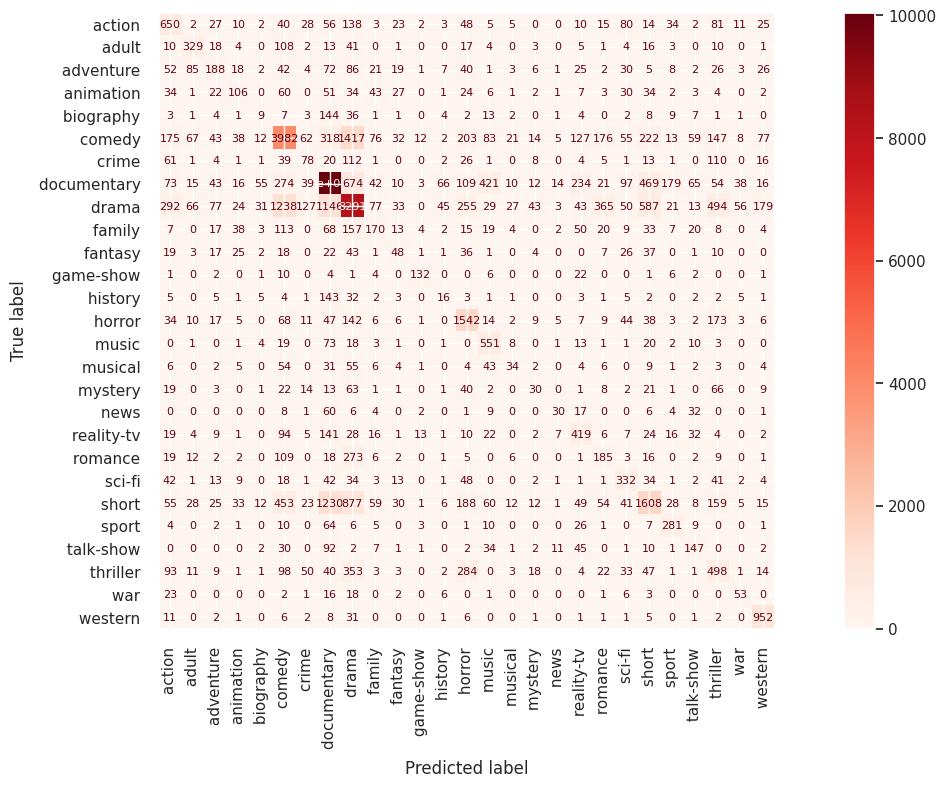

In [56]:
cm =confusion_matrix(y_actual,y_pred,labels=NB.classes_)
cmd = ConfusionMatrixDisplay(confusion_matrix=cm,display_labels=NB.classes_)
cmd.plot(cmap=plt.cm.Reds,xticks_rotation='vertical',text_kw={'size': 8})
plt.show()

In [57]:
pd.concat([pd.concat([test,y_actual],axis=1),pd.Series(y_pred)],axis=1).rename(columns={0:'Predicted_Genre'}).head(10)

,ID,TITLE,DESCRIPTION,Actual_Genre,Predicted_Genre
0,1,Edgar's Lunch (1998),LR Brane loves his life his car his apartmen...,thriller,comedy
1,2,La guerra de papá (1977),Spain March Quico is very naughty child of t...,comedy,drama
2,3,Off the Beaten Track (2010),One year in the life of Albin and his family ...,documentary,documentary
3,4,Meu Amigo Hindu (2015),His father has died he hasnt spoken with his ...,drama,drama
4,5,Er nu zhai (1955),Before he was known internationally as martia...,drama,action
5,6,Riddle Room (2016),Emily Burns is being held captive in room wit...,horror,thriller
6,7,L'amica (1969),The beautiful but neglected wife of brilliant...,drama,drama
7,8,Ina Mina Dika (1989),Vasu Inamdar Ina suffers from disorder where ...,comedy,comedy
8,9,Equinox Special: Britain's Tornados (2005),An insight into the tornados that hit Kensal ...,documentary,documentary
9,10,Press (2011),Press is story of young people overwhelmed by...,drama,documentary


# **Another approach to inhance accuracy**

**We got low accuracy due to insufficient data for other categories.** **So the model trained alot about drama and documentary movies**   **so it's hard to discover the others**

In [58]:
train_d = pd.read_csv("/content/train_data.txt", sep=':::', header=None, names=['ID', 'TITLE', 'GENRE', 'DESCRIPTION']).reset_index(drop=True)

y_actual_d = pd.read_csv(r"/content/test_data_solution.txt", sep=':::',usecols=[2],header=None).rename(columns={2:'GENRE'})

In [59]:
def make_genre_groups(df):
    genre_mapping = {
        "biography": "documentary",
        "history": "documentary",
        "mystery": "thriller",
        "horror": "thriller",
        "adventure": "action",
        "sci-fi": "action",
        "fantasy": "action",
        "romance": "comedy",
        "short": "other",
        "western": "other",
        "reality-tv": "other",
        "family": "other",
        "music": "other",
        "adult": "other",
        "crime": "other",
        "animation": "other",
        "sport": "other",
        "talk-show": "other",
        "musical": "other",
        "game-show": "other",
        "news": "other",
        "war": "other"
    }

    # Strip whitespaces from the 'GENRE' column
    df['GENRE'] = df['GENRE'].str.strip()

    # Apply the mapping
    df['GENRE'] = df['GENRE'].map(genre_mapping).fillna(df['GENRE'])

    return df

In [60]:
# Before applying the mapping
print("Before Mapping:")
print(train_d['GENRE'].unique())


Before Mapping:
[' drama ' ' thriller ' ' adult ' ' documentary ' ' comedy ' ' crime '
 ' reality-tv ' ' horror ' ' sport ' ' animation ' ' action ' ' fantasy '
 ' short ' ' sci-fi ' ' music ' ' adventure ' ' talk-show ' ' western '
 ' family ' ' mystery ' ' history ' ' news ' ' biography ' ' romance '
 ' game-show ' ' musical ' ' war ']


In [61]:
# Before applying the mapping
print("Before Mapping:")
print(y_actual_d['GENRE'].unique())


Before Mapping:
[' thriller ' ' comedy ' ' documentary ' ' drama ' ' horror ' ' short '
 ' western ' ' family ' ' sport ' ' romance ' ' war ' ' game-show '
 ' biography ' ' adult ' ' talk-show ' ' action ' ' music ' ' crime '
 ' animation ' ' sci-fi ' ' adventure ' ' reality-tv ' ' fantasy '
 ' mystery ' ' history ' ' news ' ' musical ']


In [62]:
# Apply the mapping
train_d = make_genre_groups(train_d)
y_actual_d = make_genre_groups(y_actual_d)

In [63]:
# After applying the mapping
print("\nAfter Mapping:")
print(train_d['GENRE'].unique())


After Mapping:
['drama' 'thriller' 'other' 'documentary' 'comedy' 'action']


In [64]:
# After applying the mapping
print("\nAfter Mapping:")
print(y_actual_d['GENRE'].unique())


After Mapping:
['thriller' 'comedy' 'documentary' 'drama' 'other' 'action']


In [65]:
train_d.head()

,ID,TITLE,GENRE,DESCRIPTION
0,1,Oscar et la dame rose (2009),drama,Listening in to a conversation between his do...
1,2,Cupid (1997),thriller,A brother and sister with a past incestuous r...
2,3,"Young, Wild and Wonderful (1980)",other,As the bus empties the students for their fie...
3,4,The Secret Sin (1915),drama,To help their unemployed father make ends mee...
4,5,The Unrecovered (2007),drama,The film's title refers not only to the un-re...


In [66]:
genre_distribution = train_d['GENRE'].value_counts()
# Display summary statistics
print(genre_distribution)

drama          13613
documentary    13604
other          11704
comedy          8119
thriller        4114
action          3060
Name: GENRE, dtype: int64


In [67]:
y_actual_d.head()

,GENRE
0,thriller
1,comedy
2,documentary
3,drama
4,drama


In [68]:
genre_distribution = y_actual_d['GENRE'].value_counts()
# Display summary statistics
print(genre_distribution)

drama          13612
documentary    13603
other          11698
comedy          8118
thriller        4112
action          3057
Name: GENRE, dtype: int64


# **Genre Distribution After Merging**

In [69]:
genre = train_d['GENRE'].value_counts()
fig = px.bar(genre, x=genre.index, y=genre, title='Genre Distribution', color=genre.index)
fig.update_layout(xaxis_title='GENRE', yaxis_title='Count')
fig.show()

In [70]:
genre = y_actual_d['GENRE'].value_counts()
fig = px.bar(genre, x=genre.index, y=genre, title='Genre Distribution', color=genre.index)
fig.update_layout(xaxis_title='GENRE', yaxis_title='Count')
fig.show()

In [71]:
y_train_modified = train_d['GENRE'].apply(lambda genre: genre if genre.strip() in ['drama','documentary'] else 'other')
y_actual_modified = y_actual_d['GENRE'].apply(lambda genre: genre if genre.strip() in ['drama','documentary'] else 'other')

In [72]:
NB = MultinomialNB(alpha=0.3)
start_time = time()
NB.fit(x_train,y_train_modified)
y_pred_d = NB.predict(x_test)
print('Accuracy :',accuracy_score(y_actual_modified,y_pred))
end_time = time()
print('Running Time : ',round(end_time - start_time,2),'Secounds')

Accuracy : 0.0
Running Time :  0.33 Secounds


**The accuracy increased since the model can capture drama and documentary genres clearly and make (other) for another genres**

In [73]:
print(classification_report(y_actual_d,y_pred_d))

              precision    recall  f1-score   support

      action       0.00      0.00      0.00      3057
      comedy       0.00      0.00      0.00      8118
 documentary       0.79      0.65      0.71     13603
       drama       0.75      0.26      0.38     13612
       other       0.26      0.85      0.40     11698
    thriller       0.00      0.00      0.00      4112

    accuracy                           0.41     54200
   macro avg       0.30      0.29      0.25     54200
weighted avg       0.44      0.41      0.36     54200



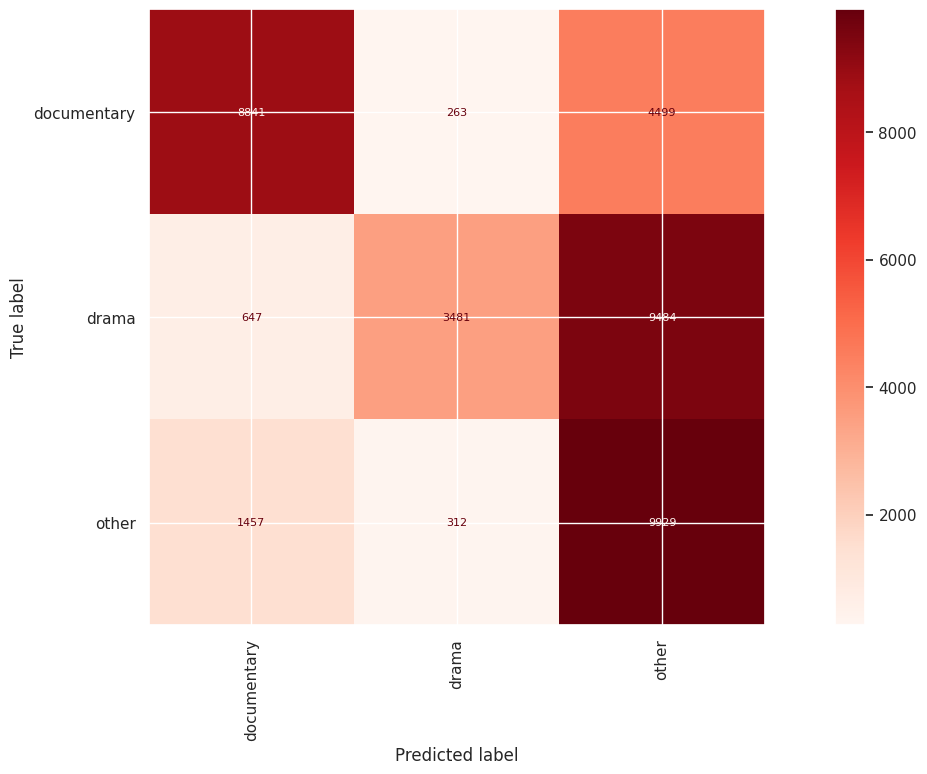

In [74]:
cm =confusion_matrix(y_actual_d,y_pred_d,labels=NB.classes_)
cmd = ConfusionMatrixDisplay(confusion_matrix=cm,display_labels=NB.classes_)
cmd.plot(cmap=plt.cm.Reds,xticks_rotation='vertical',text_kw={'size': 8})
plt.show()

# **ROC-AUC Curve**

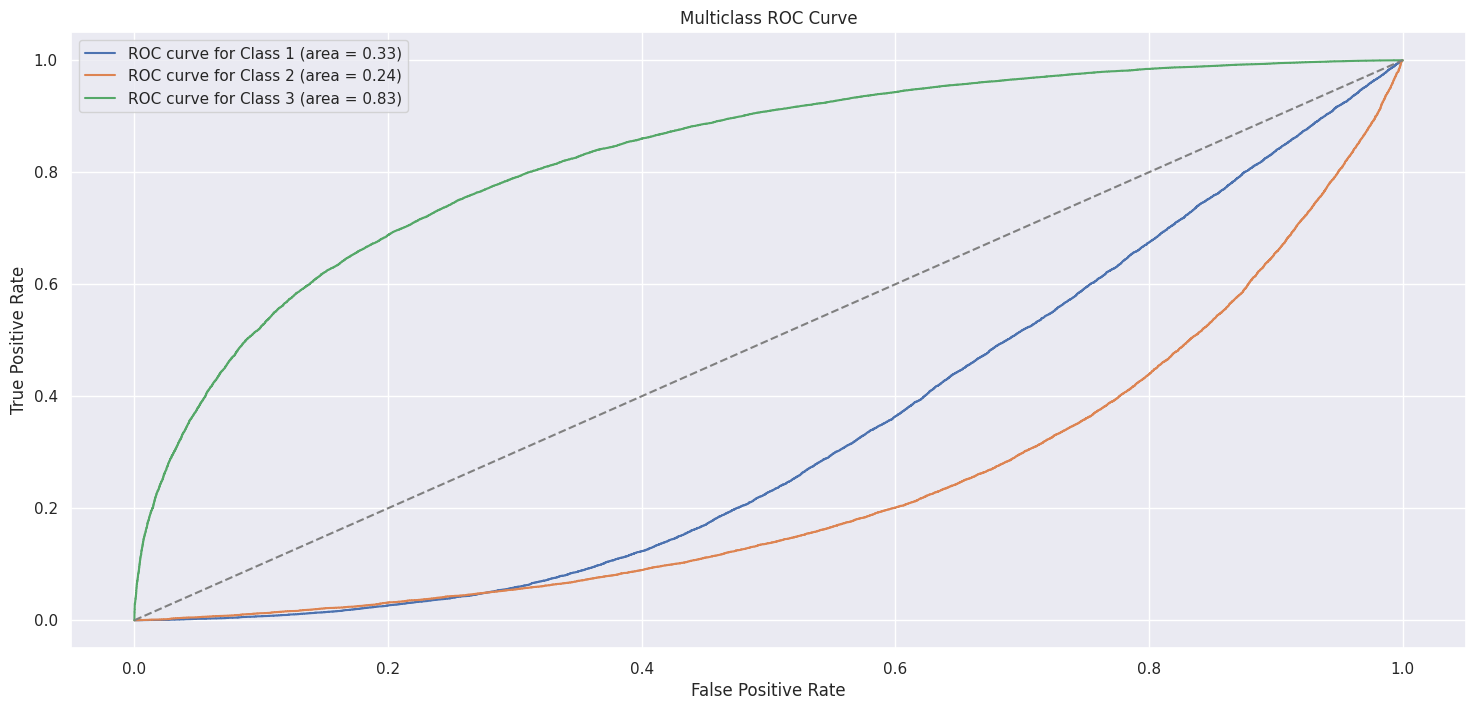

ROC-AUC for Class 1: 0.33
ROC-AUC for Class 2: 0.24
ROC-AUC for Class 3: 0.83


In [75]:
from sklearn.metrics import roc_auc_score, roc_curve
import matplotlib.pyplot as plt
from sklearn.preprocessing import label_binarize
from sklearn.multiclass import OneVsRestClassifier
from sklearn.naive_bayes import MultinomialNB
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split

# Assuming 'y_actual_modified' is the actual labels and 'NB' is the Naive Bayes model

# Binarize the labels
y_actual_bin = label_binarize(y_actual_modified, classes=['drama', 'documentary', 'other'])

# Use OneVsRestClassifier to handle multiclass ROC-AUC
ovr_classifier = OneVsRestClassifier(MultinomialNB(alpha=0.3))

# Fit the model
ovr_classifier.fit(x_train, y_train_modified)

# Predict probabilities
y_prob = ovr_classifier.predict_proba(x_test)

# Compute ROC-AUC score for each class
roc_auc = []
for i in range(y_actual_bin.shape[1]):
    roc_auc_class = roc_auc_score(y_actual_bin[:, i], y_prob[:, i])
    roc_auc.append(roc_auc_class)
    fpr, tpr, _ = roc_curve(y_actual_bin[:, i], y_prob[:, i])
    plt.plot(fpr, tpr, label=f'ROC curve for Class {i + 1} (area = {roc_auc_class:.2f})')

# Plot the ROC curve
plt.plot([0, 1], [0, 1], linestyle='--', color='gray')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Multiclass ROC Curve')
plt.legend()
plt.show()

# Display ROC-AUC score for each class
for i, auc in enumerate(roc_auc):
    print(f'ROC-AUC for Class {i + 1}: {auc:.2f}')

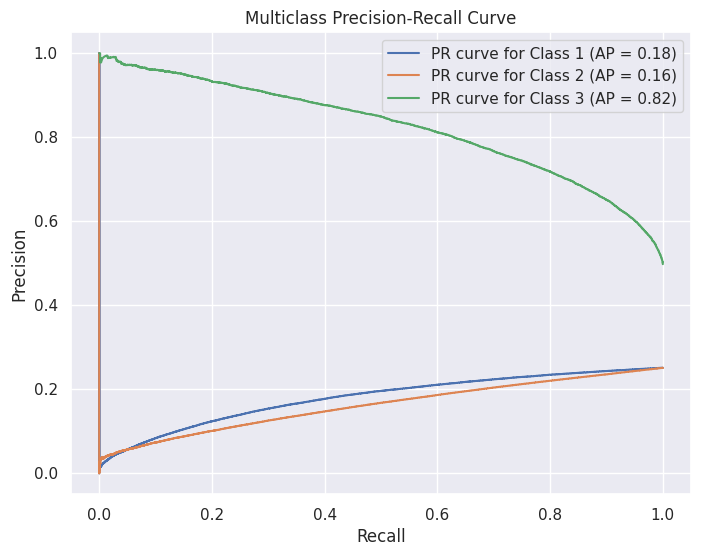

Average Precision for Class 1: 0.00
Average Precision for Class 2: 1.00
Average Precision for Class 3: 2.00


In [76]:
from sklearn.metrics import precision_recall_curve, average_precision_score
import matplotlib.pyplot as plt

# Assuming 'y_actual_bin' is the binarized actual labels and 'y_prob' is the predicted probabilities

# Compute precision-recall curve for each class
precision = dict()
recall = dict()
average_precision = dict()

for i in range(y_actual_bin.shape[1]):
    precision[i], recall[i], _ = precision_recall_curve(y_actual_bin[:, i], y_prob[:, i])
    average_precision[i] = average_precision_score(y_actual_bin[:, i], y_prob[:, i])

# Plot Precision-Recall curve for each class
plt.figure(figsize=(8, 6))

for i in range(y_actual_bin.shape[1]):
    plt.plot(recall[i], precision[i], label=f'PR curve for Class {i + 1} (AP = {average_precision[i]:.2f})')

plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Multiclass Precision-Recall Curve')
plt.legend()
plt.show()

# Display average precision for each class
for i, ap in enumerate(average_precision):
    print(f'Average Precision for Class {i + 1}: {ap:.2f}')

# **Model Optimization**

**High Bias (Underfitting):**

If the model has high bias, it means it's too simple and unable to capture the underlying patterns in the data.
Check the performance on the training set. **If the accuracy is low, it indicates underfitting.**

**High Variance (Overfitting):**

If the model has high variance, it means it's too complex and memorizing the training data without generalizing well to new data.
Check the performance on the test set. **If the accuracy is significantly lower than the training set, it indicates overfitting.**

**Optimal Model:**

Look for a balance between bias and variance. The model should generalize well to new, unseen data.
Monitor the performance on both the training and test sets.
Bias-Variance Tradeoff Plot:

We can create **learning curve by varying the model complexity (e.g., alpha values in your Naive Bayes model)** and o**bserving how bias and variance change**.
Plot the training and test accuracy or error against the complexity parameter.

*We can further **Hypertune Parameters** to make an **optimizable model** based upon the required expectations and conditions.*

# **Bias-Variance TradeOff**

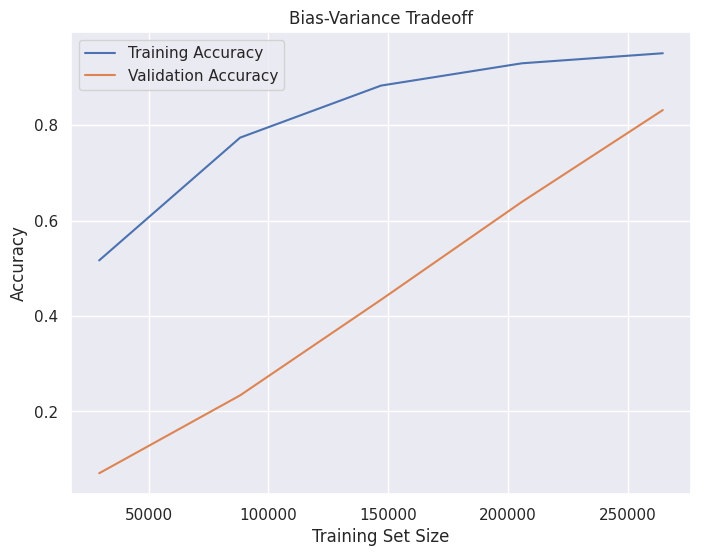

In [77]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import learning_curve
from sklearn.naive_bayes import MultinomialNB

# Assuming x_train_resampled and y_train_resampled are sparse matrices (CSR matrices)
X_train = x_train_resampled  # No need to convert to NumPy array
y_train = y_train_resampled.to_numpy()

alphas = [0.1, 0.5, 1.0, 1.5]

train_sizes, train_scores, test_scores = learning_curve(
    MultinomialNB(),
    X_train,
    y_train,
    train_sizes=[0.1, 0.3, 0.5, 0.7, 0.9],
    cv=5,
    scoring='accuracy',
    n_jobs=-1
)

# Plotting
plt.figure(figsize=(8, 6))
plt.plot(train_sizes, np.mean(train_scores, axis=1), label='Training Accuracy')
plt.plot(train_sizes, np.mean(test_scores, axis=1), label='Validation Accuracy')
plt.xlabel('Training Set Size')
plt.ylabel('Accuracy')
plt.title('Bias-Variance Tradeoff')
plt.legend()
plt.show()

**We can analyze the tradeoff between bias and variance for optimal model performance.**

# **Cross Validation**

We can implement k-fold cross-validation to assess model generalization.
But it all depends upon the required expectations